In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import font_manager

# -------------------------
# Parameters and grid setup
# -------------------------
nx, ny = 200, 200        # grid size
Lx, Ly = 5.0, 5.0      # physical domain size
dx = Lx / nx
dy = Ly / ny

x = np.linspace(-Lx/2, Lx/2, nx)
y = np.linspace(-Ly/2, Ly/2, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# mu parameters
sigma_tilde = 1
sigma_other = 0.7
tilde_mean_x, tilde_mean_y = 0.0, 0.0
other_mean_x, other_mean_y = 1.0, 1.0

figures_path = 'figures/diffusion_sim'
os.makedirs(figures_path, exist_ok=True)

In [2]:
# figures format 
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 20
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{newtxmath} \usepackage{newtxtext} \usepackage{newtxtext}'
plt.rcParams['font.serif'] = "Times New Roman"
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.edgecolor'] = 'none'

font_name = "Times New Roman"  # Change to any other installed serif font if needed

# Set font properties using the font name
font_properties = font_manager.FontProperties(family=font_name, size=18)

# fonts 
legend_fontsize = 42
label_fontsize = 38
tick_fontsize = 42
alpha = 0.7

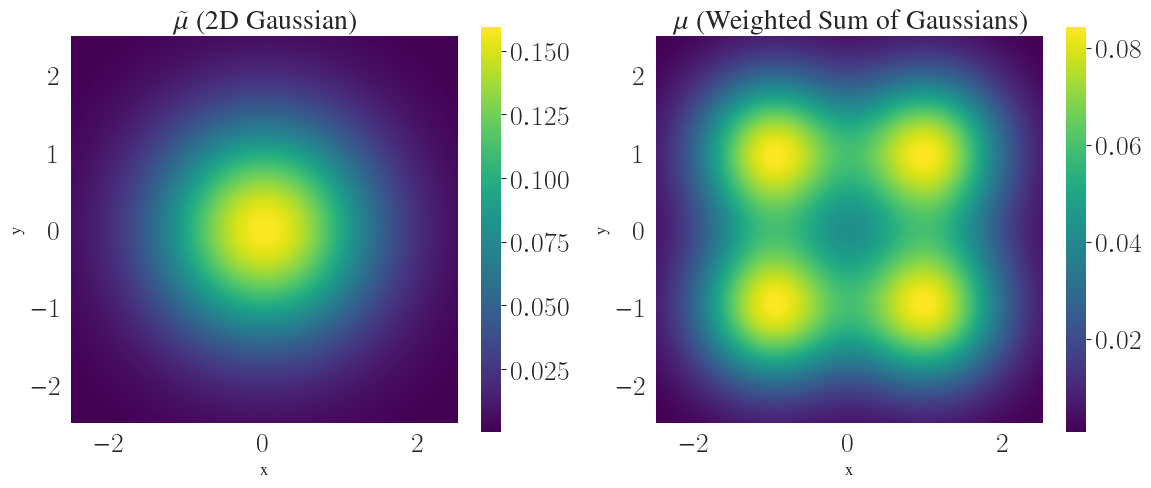

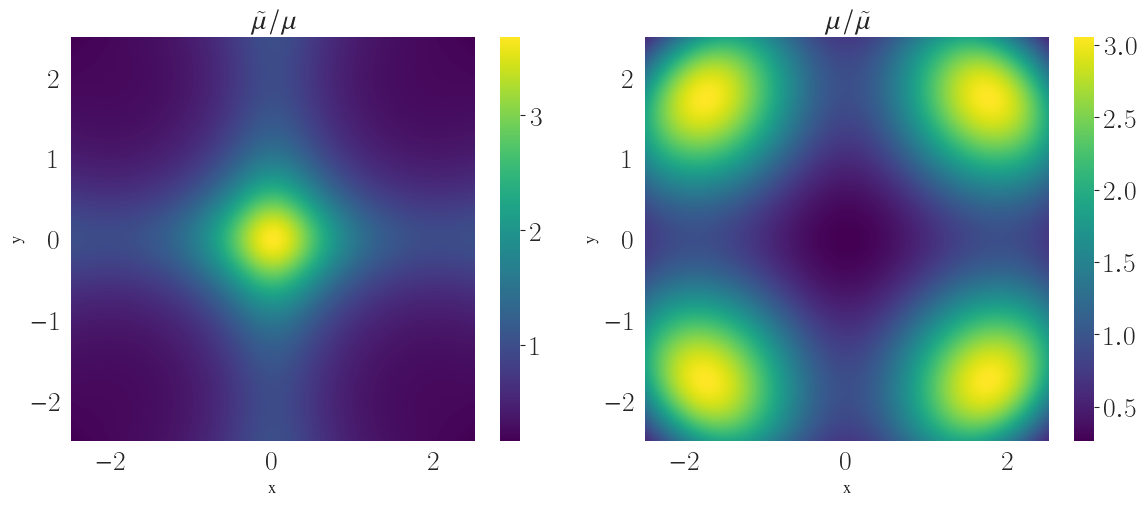

In [3]:
# -------------------------
# Define the densities
# -------------------------
def gaussian_2d(X, Y, x0, y0, sigma):
    """2D Gaussian normalized so that the integral is 1."""
    norm = 2 * np.pi * sigma**2
    return np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2)) / norm

# tilde_mu: a standard 2D Gaussian centered at (0,0)
tilde_mu = gaussian_2d(X, Y, tilde_mean_x, tilde_mean_y, sigma_tilde)

# # Another Gaussian for mu: shifted (e.g., to (1,1)) or with a different width.
# mu_other = gaussian_2d(X, Y, other_mean_x, other_mean_y, sigma_other)

# Combine to form mu. For example, with weight alpha for tilde_mu:
# alpha = 0.8
# mu = alpha * tilde_mu + (1 - alpha) * mu_other
mu = 0.25*(gaussian_2d(X, Y, 1, -1, sigma_other) + gaussian_2d(X, Y, -1, -1, sigma_other) + gaussian_2d(X, Y, -1, 1, sigma_other) + gaussian_2d(X, Y, 1, 1, sigma_other))
# mu = gaussian_2d(0.8*X, 1.2*Y, tilde_mean_x, tilde_mean_y, sigma_tilde)

# -------------------------
# Plotting tilde_mu and mu
# -------------------------
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes2[0].imshow(tilde_mu, extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                      origin='lower', cmap='viridis')
axes2[0].set_title(r"$\tilde{\mu}$ (2D Gaussian)")
axes2[0].set_xlabel("x")
axes2[0].set_ylabel("y")
fig2.colorbar(im0, ax=axes2[0])

im1 = axes2[1].imshow(mu, extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                      origin='lower', cmap='viridis')
axes2[1].set_title(r"$\mu$ (Weighted Sum of Gaussians)")
axes2[1].set_xlabel("x")
axes2[1].set_ylabel("y")
fig2.colorbar(im1, ax=axes2[1])

plt.tight_layout()
plt.savefig(f'{figures_path}/distributions.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.show()

fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes2[0].imshow(tilde_mu / (mu + 1e-3), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                      origin='lower', cmap='viridis')
axes2[0].set_title(r"$\tilde{\mu}/\mu$")
axes2[0].set_xlabel("x")
axes2[0].set_ylabel("y")
fig2.colorbar(im0, ax=axes2[0])

im1 = axes2[1].imshow(mu / (tilde_mu + 1e-3), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                      origin='lower', cmap='viridis')
axes2[1].set_title(r"$\mu/\tilde{\mu}$")
axes2[1].set_xlabel("x")
axes2[1].set_ylabel("y")
fig2.colorbar(im1, ax=axes2[1])

plt.tight_layout()
plt.savefig(f'{figures_path}/distributions_ratio.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.show()

In [4]:
# -------------------------
# Finite difference helpers
# -------------------------

# zero pad laplacian 
# def laplacian(F, dx):
#     """
#     Compute the Laplacian of F using central differences with zero padding.
#     Assumes F is defined on an (nx, ny) grid and outside values are zero.
#     """
#     # Pad F with one layer of zeros on all sides
#     F_padded = np.pad(F, pad_width=1, mode='constant', constant_values=0)
#     # Compute finite differences using the padded array.
#     lap = (F_padded[2:, 1:-1] + F_padded[:-2, 1:-1] +
#            F_padded[1:-1, 2:] + F_padded[1:-1, :-2] - 4 * F) / dx**2
#     return lap

# periodic laplacian
def laplacian(F, dx):
    """
    Compute the Laplacian of F using central differences with periodic boundary conditions.
    Assumes F is defined on an (nx, ny) grid and uses np.roll to retrieve values from the opposite side.
    """
    lap = (np.roll(F, 1, axis=0) + np.roll(F, -1, axis=0) +
           np.roll(F, 1, axis=1) + np.roll(F, -1, axis=1) - 4 * F) / dx**2
    return lap

def gradient(F, dx):
    """
    Compute the gradient of F using central differences with zero padding.
    Returns (grad_x, grad_y) arrays of the same shape as F.
    """
    F_padded = np.pad(F, pad_width=1, mode='constant', constant_values=0)
    grad_x = (F_padded[2:, 1:-1] - F_padded[:-2, 1:-1]) / (2 * dx)
    grad_y = (F_padded[1:-1, 2:] - F_padded[1:-1, :-2]) / (2 * dx)
    return grad_x, grad_y
# -------------------------
# Diffusion operator S_ε
# -------------------------
def S_epsilon(f, mu, tilde_mu, epsilon1, stabilize_factor=1e-4):
    # -------------------------
    # Precompute terms that do not depend on f
    # -------------------------
    ratio = tilde_mu / (mu + stabilize_factor)
    lap_ratio = laplacian(ratio * f, dx)
    grad_mu_x, grad_mu_y = gradient(mu, dx)
    lap_mu = laplacian(mu, dx)
    

    # Compute derivatives of f
    lap_f = laplacian(f, dx)
    grad_f_x, grad_f_y = gradient(f, dx)
    
    # Dot product between gradients of f and mu
    dot_grad = grad_f_x * grad_mu_x + grad_f_y * grad_mu_y
    
    # Compute the bracketed term in the operator
    bracket = (lap_f +
               (mu / (tilde_mu + stabilize_factor)) * lap_ratio +
               (2 * dot_grad) / (mu + stabilize_factor) -
               f * lap_mu / (mu + stabilize_factor))
    
    # Apply operator S_ε
    f_new = ratio * (f - epsilon1 * bracket)
    return f_new

def S_epsilon_equal_views(f, mu, tilde_mu, epsilon1, stabilize_factor=1e-4):
    # -------------------------
    # Precompute terms that do not depend on f
    # -------------------------
    ratio = tilde_mu / (mu + stabilize_factor)
    lap_ratio = laplacian(ratio * f, dx)
    grad_mu_x, grad_mu_y = gradient(mu, dx)
    grad_tilde_mu_x, grad_tilde_mu_y = gradient(tilde_mu, dx)
    lap_mu = laplacian(mu, dx)
    lap_mu_tilde = laplacian(tilde_mu, dx)
    

    # Compute derivatives of f
    lap_f = laplacian(f, dx)
    grad_f_x, grad_f_y = gradient(f, dx)
    
    # Dot product between gradients of f and mu
    dot_grad = grad_f_x * grad_mu_x + grad_f_y * grad_mu_y
    dot_grad_mu_tilde = grad_f_x * grad_tilde_mu_x + grad_f_y * grad_tilde_mu_y
    
    # Compute the bracketed term in the operator
    bracket = (3*lap_f +
               (mu / (tilde_mu + stabilize_factor)) * lap_ratio +
               (2 * dot_grad) / (mu + stabilize_factor) -
               f * lap_mu / (mu + stabilize_factor) +
               (2 * dot_grad_mu_tilde) / (tilde_mu + stabilize_factor) -
               f * lap_mu_tilde / (tilde_mu + stabilize_factor))
    
    # Apply operator S_ε
    f_new = ratio * (f - epsilon1 * bracket)
    return f_new

def S_no_ratio_epsilon(f, mu, tilde_mu, epsilon1, stabilize_factor=1e-4):
    # -------------------------
    # Precompute terms that do not depend on f
    # -------------------------
    ratio = tilde_mu / (mu + stabilize_factor)
    lap_ratio = laplacian(ratio * f, dx)
    grad_mu_x, grad_mu_y = gradient(mu, dx)
    lap_mu = laplacian(mu, dx)
    

    # Compute derivatives of f
    lap_f = laplacian(f, dx)
    grad_f_x, grad_f_y = gradient(f, dx)
    
    # Dot product between gradients of f and mu
    dot_grad = grad_f_x * grad_mu_x + grad_f_y * grad_mu_y
    
    # Compute the bracketed term in the operator
    bracket = (lap_f +
               (mu / (tilde_mu + stabilize_factor)) * lap_ratio +
               (2 * dot_grad) / (mu + stabilize_factor) -
               f * lap_mu / (mu + stabilize_factor))
    
    # Apply operator S_ε
    f_new = f - epsilon1 * bracket
    return f_new

# -------------------------
# Diffusion operator P_{F,ε}
# -------------------------
def Pf_epsilon(f, mu, tilde_mu, epsilon1, stabilize_factor=1e-4):
    # -------------------------
    # Precompute terms that do not depend on f
    # -------------------------
    grad_mu_x, grad_mu_y = gradient(mu, dx)
    grad_tilde_mu_x, grad_tilde_mu_y = gradient(tilde_mu, dx)
    

    # Compute derivatives of f
    lap_f = laplacian(f, dx)
    grad_f_x, grad_f_y = gradient(f, dx)
    
    # Dot product between gradients of f and mu
    dot_grad_mu = grad_f_x * grad_mu_x + grad_f_y * grad_mu_y
    dot_grad_mu_tilde = grad_f_x * grad_tilde_mu_x + grad_f_y * grad_tilde_mu_y
    
    # Compute the bracketed term in the operator
    bracket = (2 * lap_f +
               (2 * dot_grad_mu) / (mu + stabilize_factor) +
               (2 * dot_grad_mu_tilde) / (tilde_mu + stabilize_factor))
    
    # Apply operator Pf_ε
    f_new = f - epsilon1 * bracket
    return f_new


def Pf_epsilon_equal_views(f, mu, tilde_mu, epsilon1, stabilize_factor=1e-4):
    # -------------------------
    # Precompute terms that do not depend on f
    # -------------------------
    grad_mu_x, grad_mu_y = gradient(mu, dx)
    grad_tilde_mu_x, grad_tilde_mu_y = gradient(tilde_mu, dx)
    

    # Compute derivatives of f
    lap_f = laplacian(f, dx)
    grad_f_x, grad_f_y = gradient(f, dx)
    
    # Dot product between gradients of f and mu
    dot_grad_mu = grad_f_x * grad_mu_x + grad_f_y * grad_mu_y
    dot_grad_mu_tilde = grad_f_x * grad_tilde_mu_x + grad_f_y * grad_tilde_mu_y
    
    # Compute the bracketed term in the operator
    bracket = (4 * lap_f +
               (2 * dot_grad_mu) / (mu + stabilize_factor) +
               3*(2 * dot_grad_mu_tilde) / (tilde_mu + stabilize_factor))
    
    # Apply operator Pf_ε
    f_new = f - epsilon1 * bracket
    return f_new

def laplacian_operator(f, mu, tilde_mu, epsilon1, stabilize_factor=1e-4):
    # -------------------------
    # wrapper function for simulation the laplacian 
    # -------------------------
    
    return laplacian(f, dx)


def laplacian_bar_operator(f, mu, tilde_mu, epsilon1, stabilize_factor=1e-4):
    # -------------------------
    # Precompute terms that do not depend on f
    # -------------------------
    ratio = tilde_mu / (mu + stabilize_factor)
    lap_ratio = laplacian(ratio * f, dx)
    return (mu / (tilde_mu + stabilize_factor)) * lap_ratio

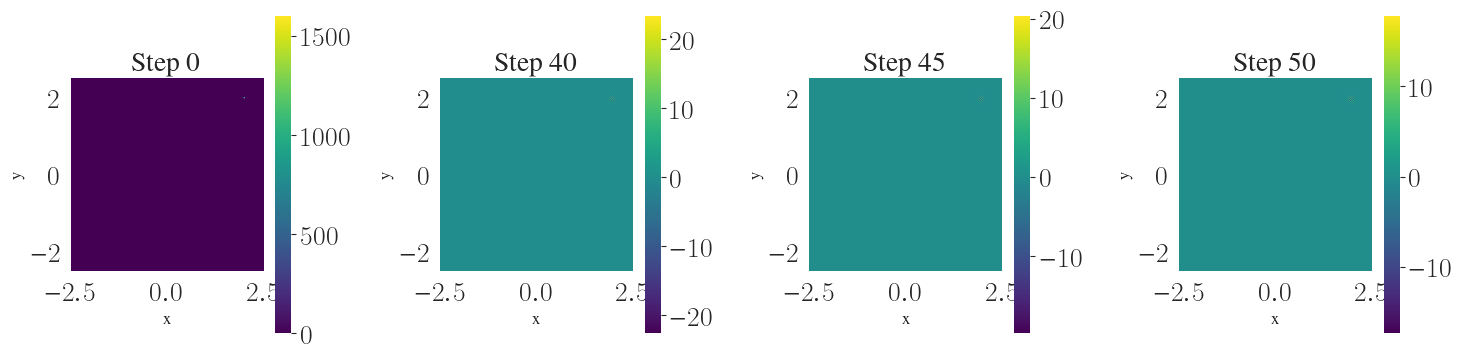

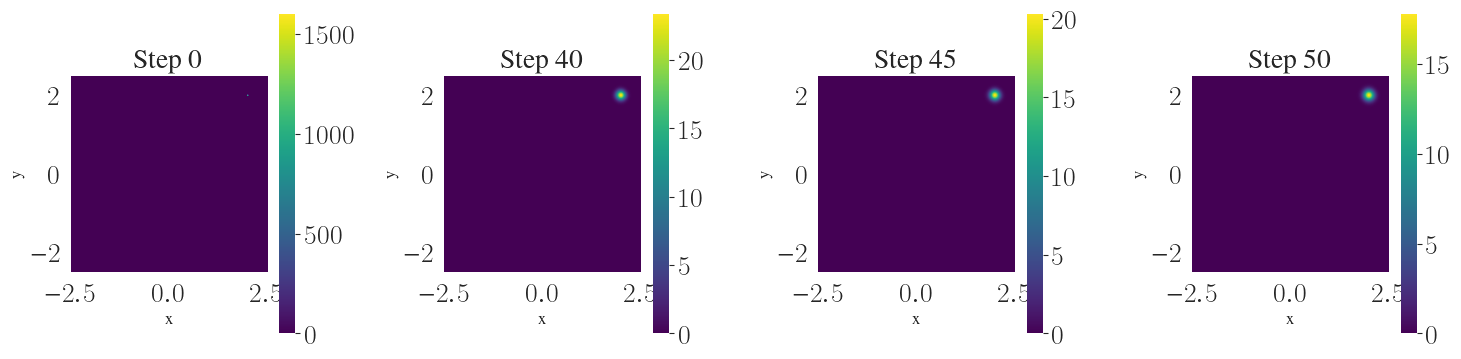

In [6]:
# -------------------------
# Initial condition for f
# -------------------------
# Approximate a delta function by putting all mass in one grid cell.
f = np.zeros((nx, ny))
# Choose the cell closest to (x_init, y_init)
x_init, y_init = 2, 2
i0 = np.argmin(np.abs(x - x_init))
j0 = np.argmin(np.abs(y - y_init))
f[i0, j0] = 1.0 / (dx * dy) # normalization: total area is 1



# -------------------------
# Time-stepping simulation
# -------------------------
epsilon1 = 0.1   # time step size (diffusion parameter)
n_steps = 500      # total number of steps
plot_steps = [0, 40, 45, 50]  # steps at which to store snapshots

# For plotting, store snapshots of f at selected time steps
f_snapshots = {}
f_snapshots_t = {}
f0 = f.copy()
for step in range(n_steps + 1):
    if step in plot_steps:
        f_snapshots[step] = f.copy()
    # Update f by applying the diffusion operator S_ε
    f = S_epsilon(f ,mu, tilde_mu, epsilon1)
    
    # Normalize f so that the total area remains 1
    total_area = np.sum(np.abs(f)) * dx * dy
    if total_area != 0:
        f /= total_area


# -------------------------
# Plotting snapshots
# -------------------------
fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(f_snapshots[step], extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/s_simulation_steps.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(np.abs(f_snapshots[step]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/s_simulation_steps_abs_x_init_{int(x_init)}_y_init_{int(y_init)}.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()



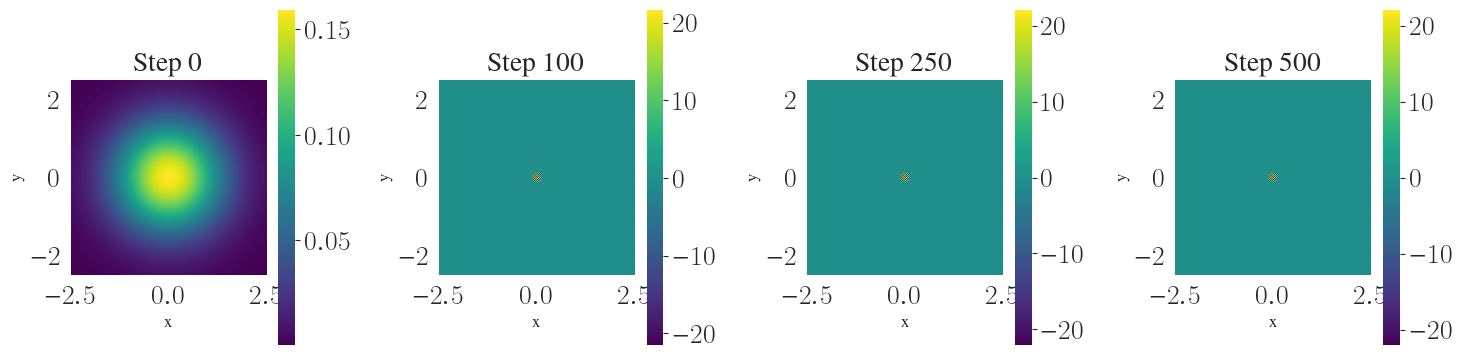

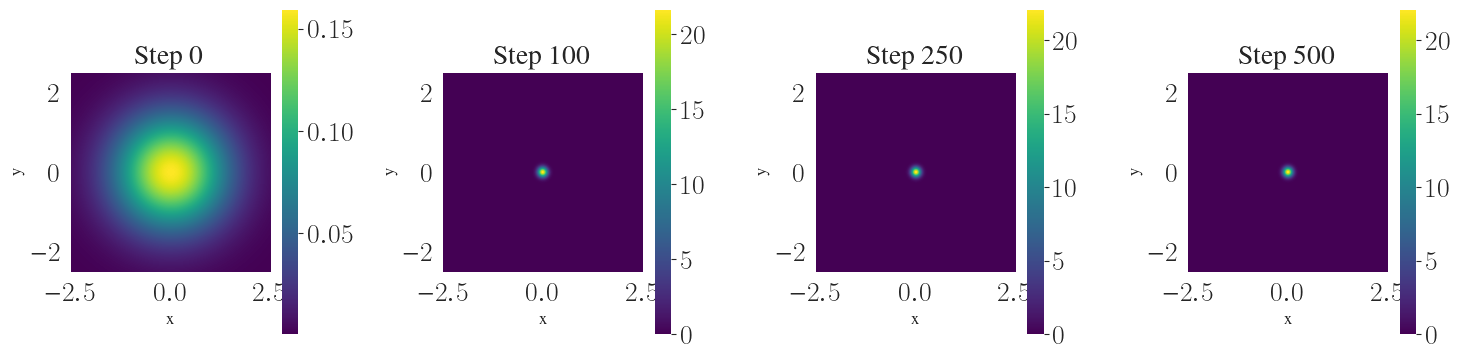

In [7]:
# Approximate a uniform function
# f = np.ones((nx, ny))
# # Normalize f 
# total_area = np.sum(np.abs(f)) * dx * dy
# if total_area != 0:
#     f /= total_area
f = tilde_mu.copy()


# -------------------------
# Time-stepping simulation
# -------------------------
epsilon1 = 0.1   # time step size (diffusion parameter)
n_steps = 500      # total number of steps
plot_steps = [0, 100, 250, 500]  # steps at which to store snapshots
# plot_steps = [0, 100, 200, 300]  # steps at which to store snapshots


# For plotting, store snapshots of f at selected time steps
f_snapshots = {}
f_snapshots_t = {}
f0 = f.copy()
for step in range(n_steps + 1):
    if step in plot_steps:
        f_snapshots[step] = f.copy()
    # Update f by applying the diffusion operator S_ε
    f = S_epsilon(f ,mu, tilde_mu, epsilon1)
    
    # Normalize f so that the total area remains 1
    total_area = np.sum(np.abs(f)) * dx * dy
    if total_area != 0:
        f /= total_area


# -------------------------
# Plotting snapshots
# -------------------------
fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(f_snapshots[step], extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/s_simulation_steps.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(np.abs(f_snapshots[step]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/s_simulation_steps_f_uniform.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


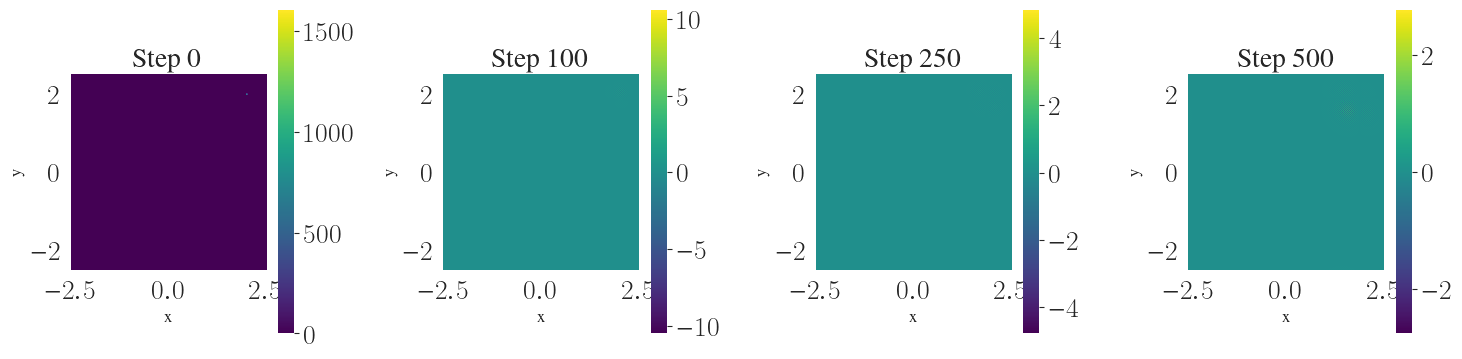

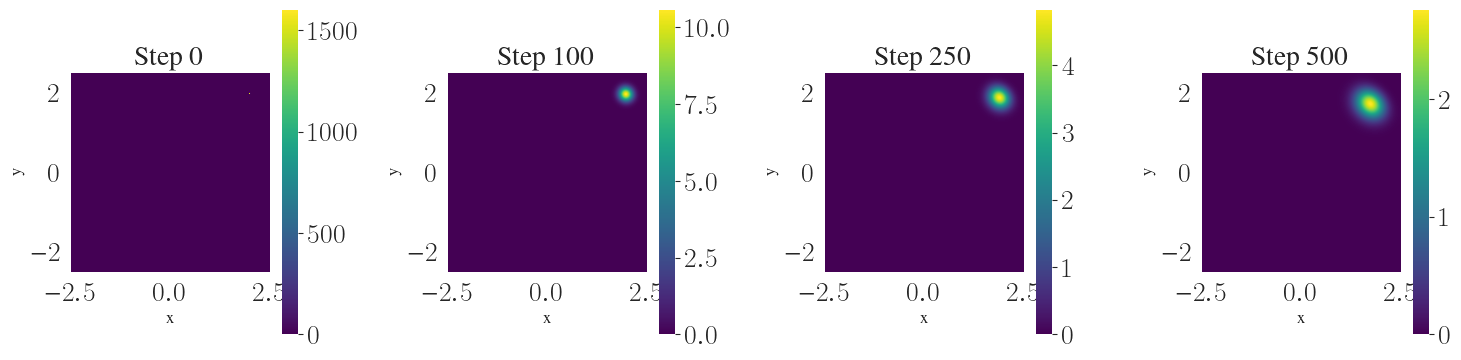

In [8]:
# -------------------------
# Initial condition for f
# -------------------------
# Approximate a delta function by putting all mass in one grid cell.
f = np.zeros((nx, ny))
# Choose the cell closest to (x_init, y_init)
# x_init, y_init = 0, 0
# i0 = np.argmin(np.abs(x - x_init))
# j0 = np.argmin(np.abs(y - y_init))
f[i0, j0] = 1.0 / (dx * dy) # normalization: total area is 1



# -------------------------
# Time-stepping simulation
# -------------------------
epsilon1 = 0.1   # time step size (diffusion parameter)
n_steps = 500      # total number of steps
plot_steps = [0, 100, 250, 500]  # steps at which to store snapshots

# For plotting, store snapshots of f at selected time steps
f_snapshots = {}
f_snapshots_t = {}
f0 = f.copy()
for step in range(n_steps + 1):
    if step in plot_steps:
        f_snapshots[step] = f.copy()
    # Update f by applying the diffusion operator S_ε
    f = S_no_ratio_epsilon(f ,mu, tilde_mu, epsilon1)
    
    # Normalize f so that the total area remains 1
    total_area = np.sum(np.abs(f)) * dx * dy
    if total_area != 0:
        f /= total_area


# -------------------------
# Plotting snapshots
# -------------------------
fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(f_snapshots[step], extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/s_nr_simulation_steps.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(np.abs(f_snapshots[step]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/s_nr_simulation_steps_abs_x_init_{int(x_init)}_y_init_{int(y_init)}.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


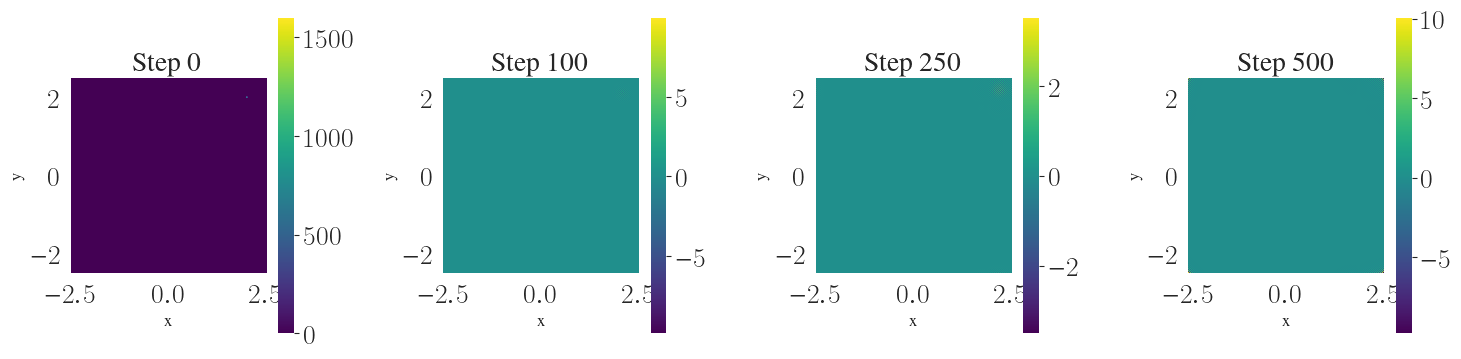

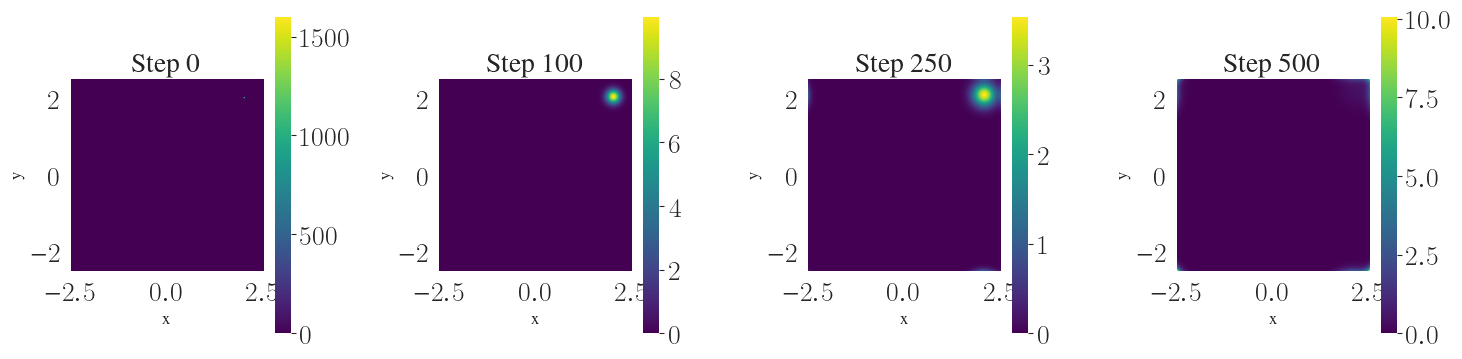

In [9]:
# -------------------------
# Initial condition for f
# -------------------------
# Approximate a delta function by putting all mass in one grid cell.
f = np.zeros((nx, ny))
# # Choose the cell closest to (x_init, y_init)
# x_init, y_init = 0, 0
# i0 = np.argmin(np.abs(x - x_init))
# j0 = np.argmin(np.abs(y - y_init))
f[i0, j0] = 1.0 / (dx * dy) # normalization: total area is 1



# -------------------------
# Time-stepping simulation
# -------------------------

# For plotting, store snapshots of f at selected time steps
f_snapshots = {}
for step in range(n_steps + 1):
    if step in plot_steps:
        f_snapshots[step] = f.copy()
    # Update f by applying the diffusion operator S_ε
    f = Pf_epsilon(f ,mu, tilde_mu, epsilon1)
    
    # Normalize f so that the total area remains 1
    total_area = np.sum(np.abs(f)) * dx * dy
    if total_area != 0:
        f /= total_area

# -------------------------
# Plotting snapshots
# -------------------------
fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(f_snapshots[step], extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/pf_simulation_steps.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(np.abs(f_snapshots[step]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/pf_simulation_steps_abs_x_init_{int(x_init)}_y_init_{int(y_init)}.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


## Quiver plots

In [5]:
# -------------------------
# Function to compute and plot the diffusion directions
# -------------------------
def plot_diffusion_quiver(diffusion_func, T, mu, tilde_mu, epsilon1, coarse_step=20, stabilize_factor=1e-4):
    """
    For each point in a coarse grid:
      1. Start with a delta function at that grid point.
      2. Apply the diffusion function T times.
      3. Compute the weighted center of mass of abs(f_T).
      4. Determine the local diffusion direction.
    A quiver plot of the directions is then produced.

    Parameters:
      diffusion_func : function
          A diffusion operator with signature f_new = diffusion_func(f, epsilon1).
      T : int
          Number of time steps to run the diffusion.
      epsilon1 : float
          The diffusion time step parameter.
      coarse_step : int
          The step size to use for the coarse grid.
    """
    # Determine coarse grid indices
    margin = coarse_step
    coarse_indices_x = np.arange(margin, nx - margin, coarse_step)
    coarse_indices_y = np.arange(margin, ny - margin, coarse_step)
    
    
    # Arrays to store quiver plot data
    U = np.zeros((len(coarse_indices_x), len(coarse_indices_y)))  # x-component of direction
    V = np.zeros((len(coarse_indices_x), len(coarse_indices_y)))  # y-component of direction
    X_coarse = np.zeros_like(U)  # x positions of coarse grid points
    Y_coarse = np.zeros_like(U)  # y positions of coarse grid points
    
    # Loop over coarse grid points
    for idx_i, i in enumerate(coarse_indices_x):
        for idx_j, j in enumerate(coarse_indices_y):
            # Initialize f as a delta function at (i, j)
            f_init = np.zeros((nx, ny))
            f_init[i, j] = 1.0 / (dx * dy)  # ensure total area = 1
            
            f_temp = f_init.copy()
            # Diffuse for T time steps, normalizing at each step
            for t in range(T):
                f_temp = diffusion_func(f_temp, mu, tilde_mu, epsilon1, stabilize_factor)
                tot = np.sum(f_temp) * dx * dy
                if tot != 0:
                    f_temp /= tot
            
            # Compute the weighted center of mass using abs(f_temp)
            tot_abs = np.sum(np.abs(f_temp)) * dx * dy
            if tot_abs == 0:
                x_mean = x[i]
                y_mean = y[j]
            else:
                x_mean = np.sum(np.abs(f_temp) * X) * dx * dy / tot_abs
                y_mean = np.sum(np.abs(f_temp) * Y) * dx * dy / tot_abs
                # abs_f = np.abs(f_temp)
                # max_idx = np.unravel_index(np.argmax(abs_f), abs_f.shape)
                # x_mean = x[max_idx[0]]
                # y_mean = y[max_idx[1]]
                
            # The local diffusion direction is from (x[i], y[j]) to (x_mean, y_mean)
            U[idx_i, idx_j] = x_mean - x[i]
            V[idx_i, idx_j] = y_mean - y[j]
            X_coarse[idx_i, idx_j] = x[i]
            Y_coarse[idx_i, idx_j] = y[j]
    
    # Create the quiver plot
    plt.figure(figsize=(8, 6))
    plt.quiver(X_coarse, Y_coarse, U, V, angles='xy', scale_units='xy', scale=1, color='black')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Local Diffusion Direction Quiver Plot')
    plt.xlim([-Lx/2, Lx/2])
    plt.ylim([-Ly/2, Ly/2])
    plt.grid(True)
    plt.show()
    return X_coarse, Y_coarse, U, V

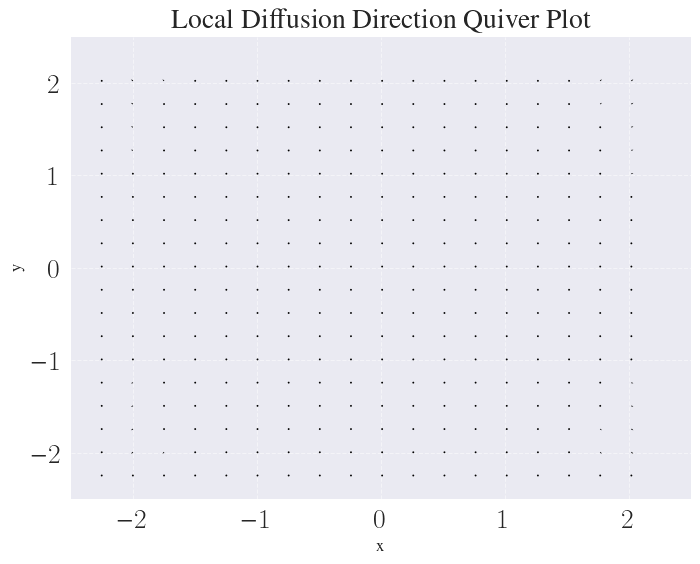

In [11]:
X_coarse, Y_coarse, U, V = plot_diffusion_quiver(Pf_epsilon_equal_views, T=50, mu=mu, tilde_mu=tilde_mu, epsilon1=0.1, coarse_step=10)

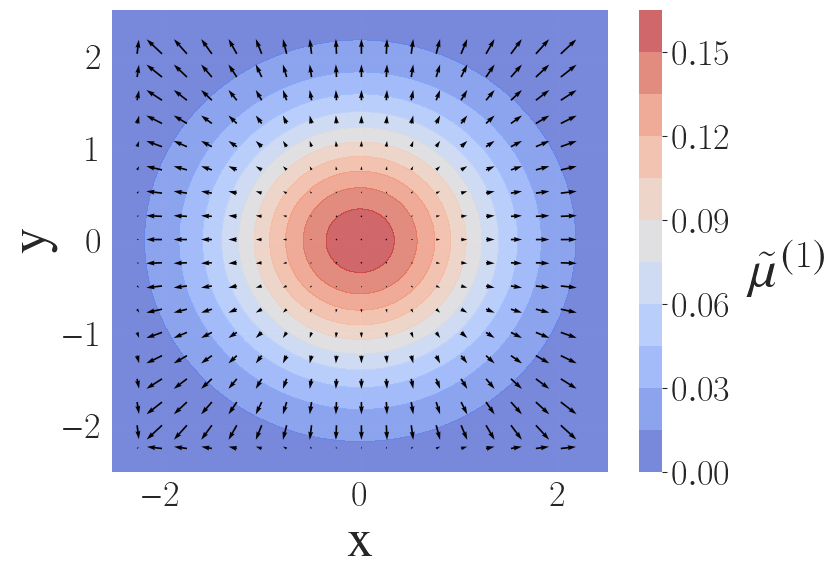

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
# contourf = ax.contourf(X, Y, tilde_mu / (mu + 1e-5), levels=10, cmap='coolwarm', alpha=alpha)
# # contourf = ax.contourf(X, Y, mu, levels=20, cmap='coolwarm', alpha=0.5)
# cbar = fig.colorbar(contourf, ax=ax)
# cbar.set_label(r'$\frac{\tilde{\mu}^{(1)}}{\mu^{(1)}}$', fontsize=label_fontsize, labelpad=22,  rotation=0)
contourf = ax.contourf(X, Y, tilde_mu, levels=10, cmap='coolwarm', alpha=alpha)
# contourf = ax.contourf(X, Y, mu, levels=20, cmap='coolwarm', alpha=0.5)
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label(r'$\tilde{\mu}^{(1)}$', fontsize=label_fontsize, labelpad=38,  rotation=0)
cbar.ax.tick_params(labelsize=26)
ax.quiver(X_coarse, Y_coarse, U, V, angles='xy', scale_units='xy', scale=0.1, color='black')
ax.set_xlabel('x', fontsize=label_fontsize)
ax.set_ylabel('y', fontsize=label_fontsize)
# plt.title('Local Diffusion Direction Quiver Plot')
ax.set_xlim([-Lx/2, Lx/2])
ax.set_ylim([-Ly/2, Ly/2])
plt.tick_params(labelsize=26)
ax.grid(True)
plt.savefig(f'{figures_path}/pf_quiver.pdf', dpi=500, format='pdf', bbox_inches='tight')

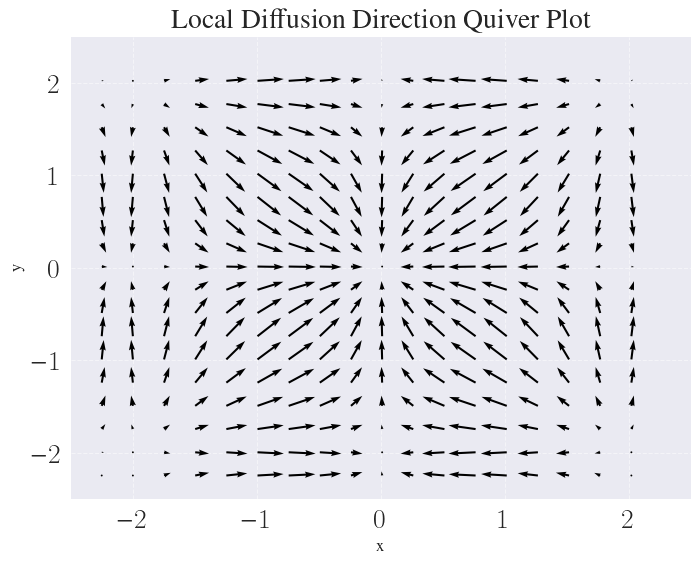

In [6]:
X_coarse, Y_coarse, U, V = plot_diffusion_quiver(S_epsilon_equal_views, T=50, mu=mu, tilde_mu=tilde_mu, epsilon1=0.1, coarse_step=10)

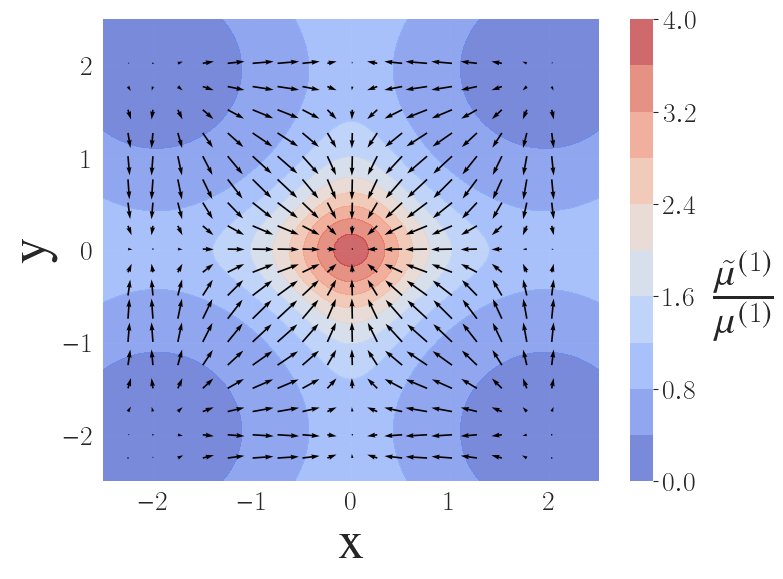

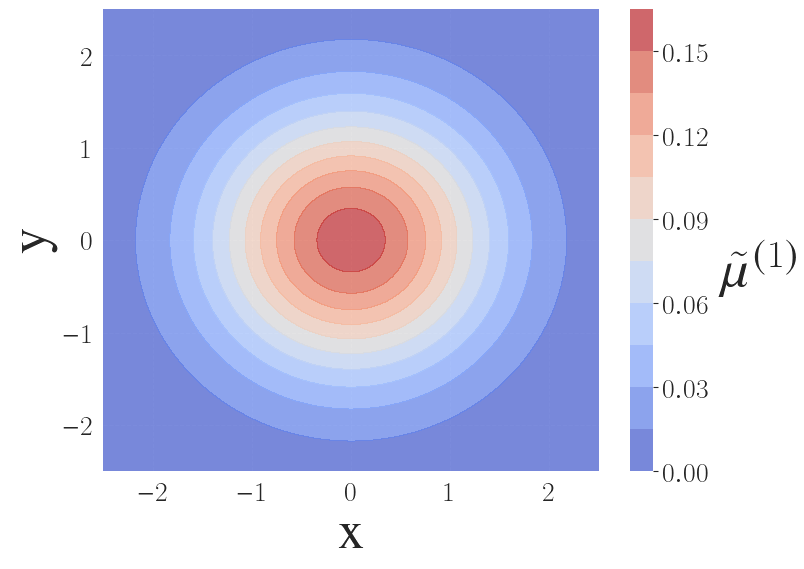

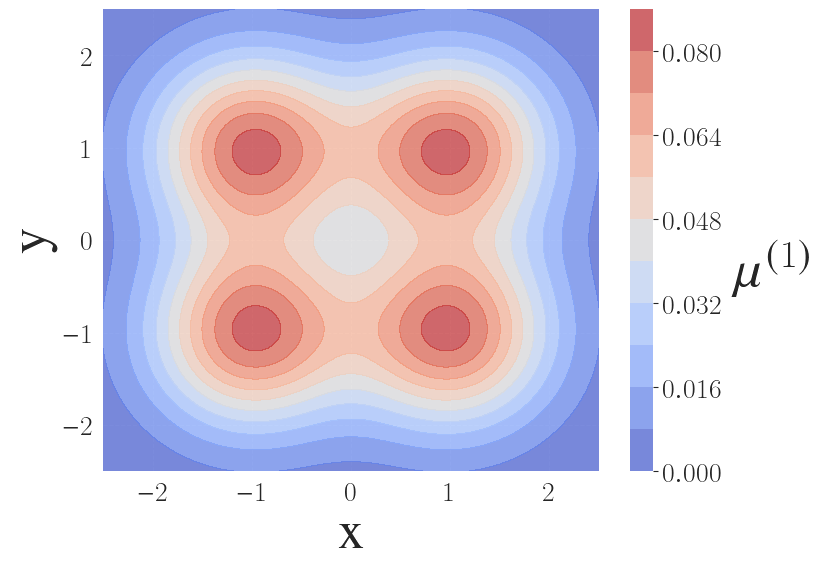

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
contourf = ax.contourf(X, Y, tilde_mu / (mu + 1e-5), levels=10, cmap='coolwarm', alpha=alpha)
# contourf = ax.contourf(X, Y, mu, levels=20, cmap='coolwarm', alpha=0.5)
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label(r'$\frac{\tilde{\mu}^{(1)}}{\mu^{(1)}}$', fontsize=label_fontsize, labelpad=34,  rotation=0) 
ax.quiver(X_coarse, Y_coarse, U, V, angles='xy', scale_units='xy', scale=1, color='black')
ax.set_xlabel('x', fontsize=label_fontsize)
ax.set_ylabel('y', fontsize=label_fontsize)
# plt.title('Local Diffusion Direction Quiver Plot')
ax.set_xlim([-Lx/2, Lx/2])
ax.set_ylim([-Ly/2, Ly/2])
ax.grid(True)
plt.savefig(f'{figures_path}/s_quiver.pdf', dpi=500, format='pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(8, 6))
contourf = ax.contourf(X, Y, tilde_mu, levels=10, cmap='coolwarm', alpha=alpha)
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label(r'$\tilde{\mu}^{(1)}$', fontsize=label_fontsize, rotation=0, labelpad=34) 
# plt.title('Local Diffusion Direction Quiver Plot')
ax.set_xlabel('x', fontsize=label_fontsize)
ax.set_ylabel('y', fontsize=label_fontsize)
ax.set_xlim([-Lx/2, Lx/2])
ax.set_ylim([-Ly/2, Ly/2])
ax.grid(True)
plt.savefig(f'{figures_path}/tilde_mu.pdf', dpi=500, format='pdf', bbox_inches='tight')
fig, ax = plt.subplots(figsize=(8, 6))
contourf = ax.contourf(X, Y, mu, levels=10, cmap='coolwarm', alpha=alpha)
# contourf = ax.contourf(X, Y, mu, levels=20, cmap='coolwarm', alpha=0.5)
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label(r'$\mu^{(1)}$', fontsize=label_fontsize, rotation=0, labelpad=34) 
ax.set_xlabel('x', fontsize=label_fontsize)
ax.set_ylabel('y', fontsize=label_fontsize)
# plt.title('Local Diffusion Direction Quiver Plot')
ax.set_xlim([-Lx/2, Lx/2])
ax.set_ylim([-Ly/2, Ly/2])
ax.grid(True)
plt.savefig(f'{figures_path}/mu.pdf', dpi=500, format='pdf', bbox_inches='tight')

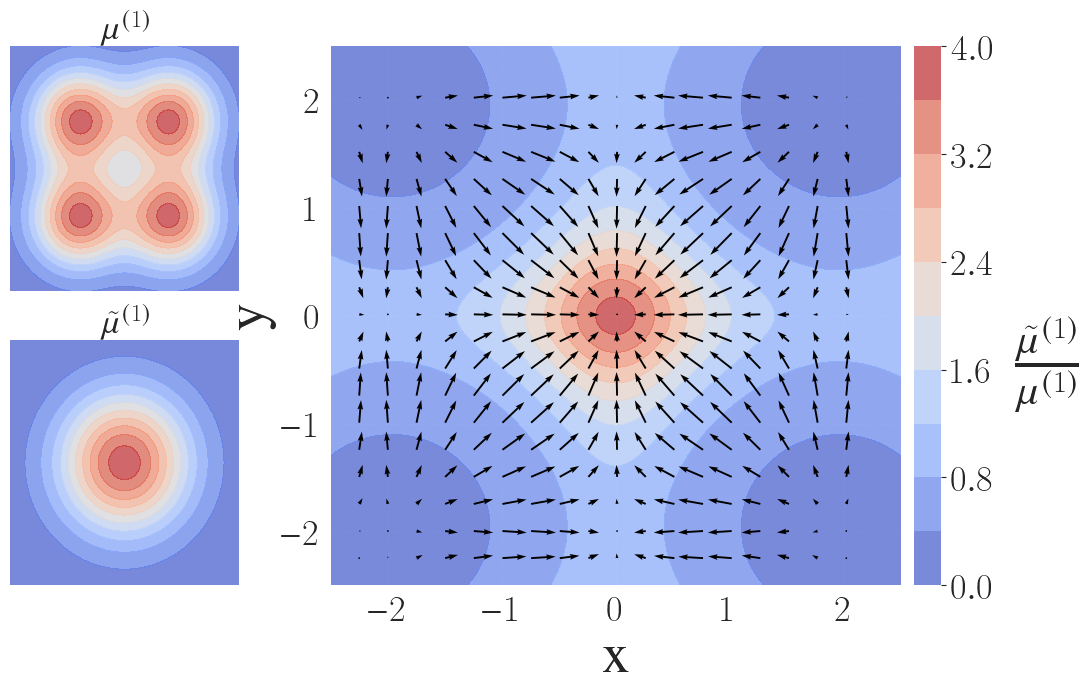

In [15]:
from matplotlib import gridspec 
fig = plt.figure(figsize=(13, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3], height_ratios=[1, 1])

# Left column: two small windows for mu and tilde_mu distributions
ax_mu = fig.add_subplot(gs[0, 0])
ax_tildemu = fig.add_subplot(gs[1, 0])

# Right column: main axis for quiver plot with μ contours
ax_main = fig.add_subplot(gs[:, 1])

# Plot the μ distribution in the upper left window
im_mu = ax_mu.contourf(X, Y, mu, levels=10, cmap='coolwarm', alpha=alpha)
ax_mu.set_title(r'$\mu^{(1)}$', fontsize=24)
ax_mu.set_xticks([])
ax_mu.set_yticks([])

# Plot the $\tilde{\mu}$ distribution in the lower left window
im_tildemu = ax_tildemu.contourf(X, Y, tilde_mu, levels=10, cmap='coolwarm', alpha=alpha)
ax_tildemu.set_title(r'$\tilde{\mu}^{(1)}$', fontsize=24)
ax_tildemu.set_xticks([])
ax_tildemu.set_yticks([])

# In the main axis, plot the filled contours for μ and the quiver plot
cf = ax_main.contourf(X, Y, tilde_mu / (mu + 1e-5), levels=10, cmap='coolwarm', alpha=alpha)
q = ax_main.quiver(X_coarse, Y_coarse, U, V, angles='xy', scale_units='xy', scale=1, color='black')
# ax_main.set_title('Local Diffusion Directions with Contours')
ax_main.set_xlabel('x', fontsize=label_fontsize + 2)
ax_main.set_ylabel('y', fontsize=label_fontsize + 2)
plt.tick_params(labelsize=26)
ax_main.set_xlim([-Lx/2, Lx/2])
ax_main.set_ylim([-Ly/2, Ly/2])
ax_main.grid(True)

# Add a colorbar for the μ contours with a vertical label
cbar = fig.colorbar(cf, ax=ax_main, orientation='vertical', pad=0.02)
cbar.set_label(r'$\frac{\tilde{\mu}^{(1)}}{\mu^{(1)}}$', fontsize=label_fontsize + 2, labelpad=38,  rotation=0)
cbar.ax.tick_params(labelsize=26)
plt.savefig(f'{figures_path}/s_joined_quiver.pdf', dpi=500, format='pdf', bbox_inches='tight')

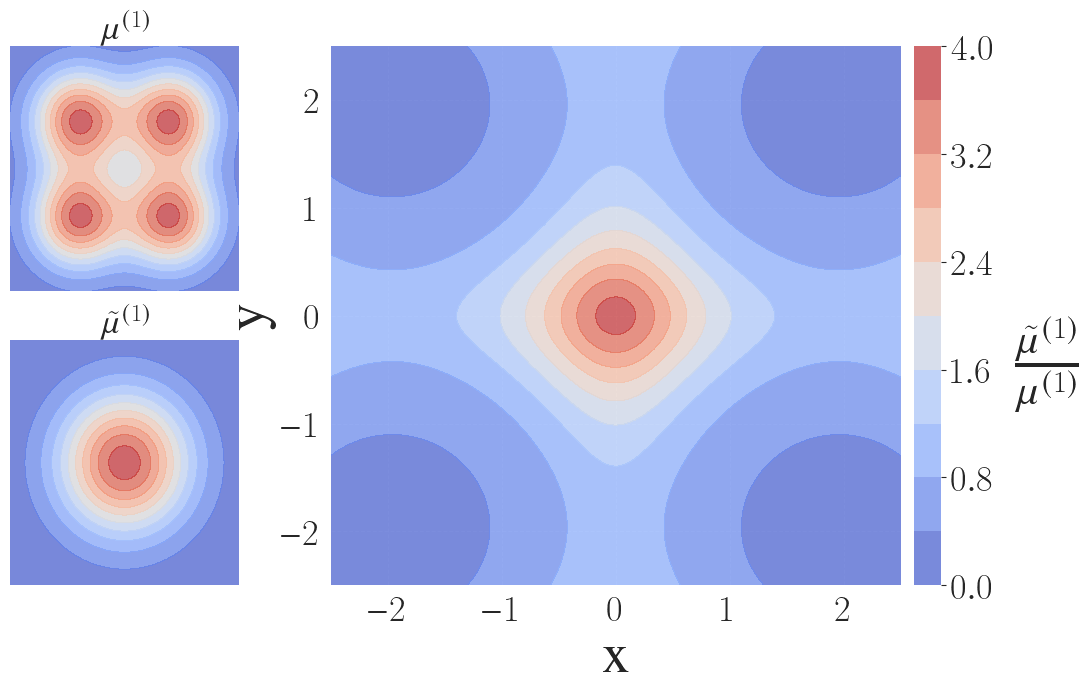

In [7]:
from matplotlib import gridspec 
fig = plt.figure(figsize=(13, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3], height_ratios=[1, 1])

# Left column: two small windows for mu and tilde_mu distributions
ax_mu = fig.add_subplot(gs[0, 0])
ax_tildemu = fig.add_subplot(gs[1, 0])

# Right column: main axis for quiver plot with μ contours
ax_main = fig.add_subplot(gs[:, 1])

# Plot the μ distribution in the upper left window
im_mu = ax_mu.contourf(X, Y, mu, levels=10, cmap='coolwarm', alpha=alpha)
ax_mu.set_title(r'$\mu^{(1)}$', fontsize=24)
ax_mu.set_xticks([])
ax_mu.set_yticks([])

# Plot the $\tilde{\mu}$ distribution in the lower left window
im_tildemu = ax_tildemu.contourf(X, Y, tilde_mu, levels=10, cmap='coolwarm', alpha=alpha)
ax_tildemu.set_title(r'$\tilde{\mu}^{(1)}$', fontsize=24)
ax_tildemu.set_xticks([])
ax_tildemu.set_yticks([])

# In the main axis, plot the filled contours for μ and the quiver plot
cf = ax_main.contourf(X, Y, tilde_mu / (mu + 1e-5), levels=10, cmap='coolwarm', alpha=alpha)
# q = ax_main.quiver(X_coarse, Y_coarse, U, V, angles='xy', scale_units='xy', scale=1, color='black')
# ax_main.set_title('Local Diffusion Directions with Contours')
ax_main.set_xlabel('x', fontsize=label_fontsize + 2)
ax_main.set_ylabel('y', fontsize=label_fontsize + 2)
plt.tick_params(labelsize=26)
ax_main.set_xlim([-Lx/2, Lx/2])
ax_main.set_ylim([-Ly/2, Ly/2])
ax_main.grid(True)

# Add a colorbar for the μ contours with a vertical label
cbar = fig.colorbar(cf, ax=ax_main, orientation='vertical', pad=0.02)
cbar.set_label(r'$\frac{\tilde{\mu}^{(1)}}{\mu^{(1)}}$', fontsize=label_fontsize + 2, labelpad=38,  rotation=0)
cbar.ax.tick_params(labelsize=26)
plt.savefig(f'{figures_path}/s_joined_no_quiver.pdf', dpi=500, format='pdf', bbox_inches='tight')

# Eigenvector Comparison Using the Power Method

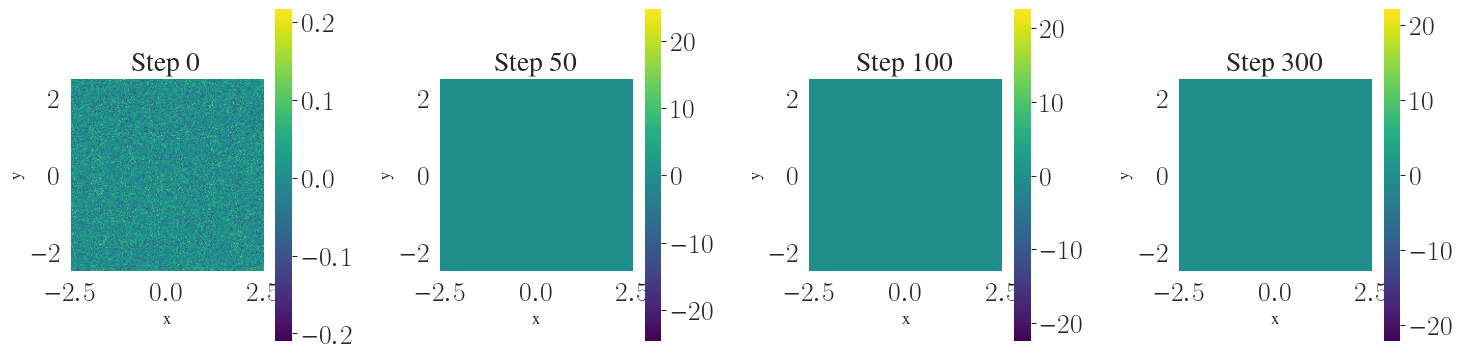

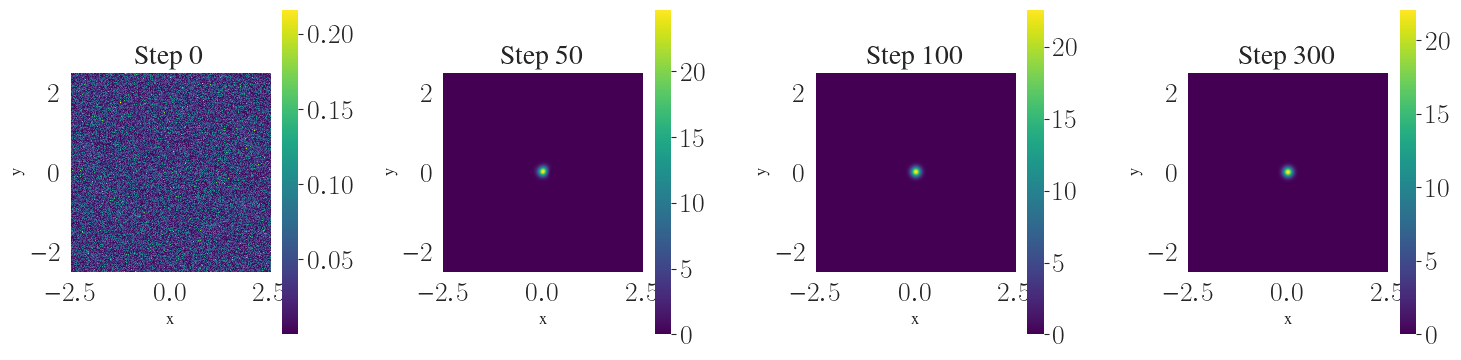

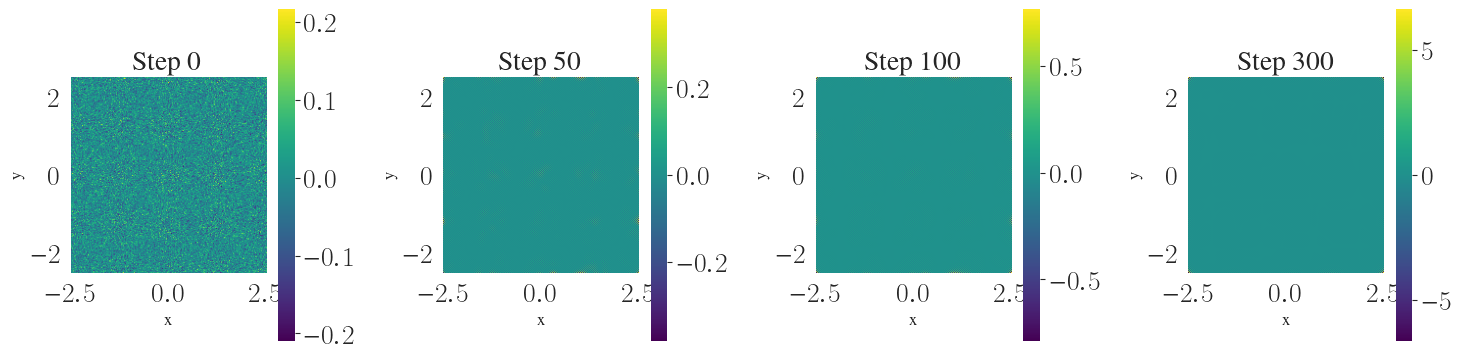

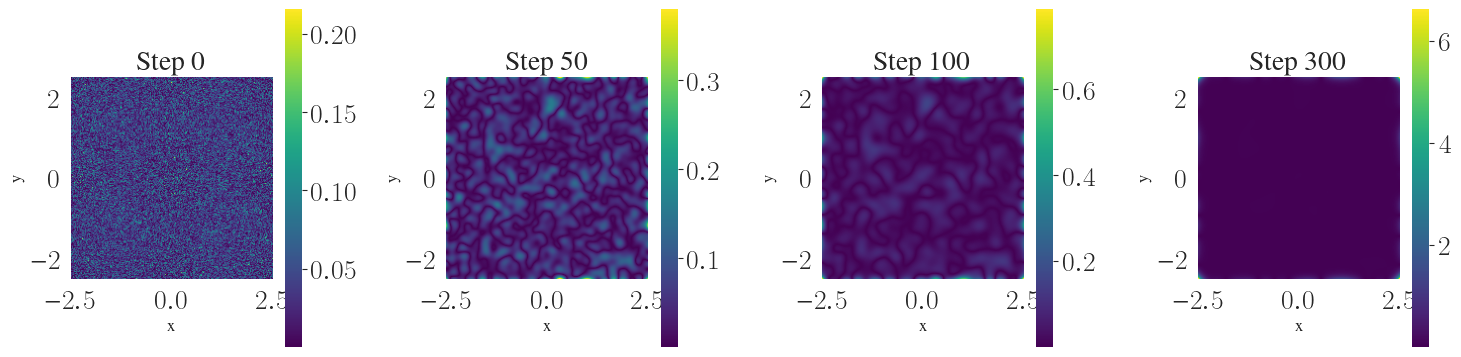

In [16]:
# -------------------------
# Initial condition for f
# -------------------------
# Approximate a delta function by putting all mass in one grid cell.
f = np.random.randn(nx, ny)
# Normalize f so that the total area remains 1
total_area = np.sum(np.abs(f)) * dx * dy
if total_area != 0:
    f /= total_area





# -------------------------
# Time-stepping simulation
# -------------------------
epsilon1 = 0.1   # time step size (diffusion parameter)
n_steps = 500      # total number of steps
plot_steps = [0, 50, 100, 300]  # steps at which to store snapshots

# For plotting, store snapshots of f at selected time steps
f_snapshots = {}
f_snapshots_t = {}
f0 = f.copy()
for step in range(n_steps + 1):
    if step in plot_steps:
        f_snapshots[step] = f.copy()
    # Update f by applying the diffusion operator S_ε
    f = S_epsilon(f ,mu, tilde_mu, epsilon1)
    f = f - np.mean(f)
    
    # Normalize f so that the total area remains 1
    total_area = np.sum(np.abs(f)) * dx * dy
    if total_area != 0:
        f /= total_area


# -------------------------
# Plotting snapshots
# -------------------------
fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(f_snapshots[step], extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/s_eigenvector.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(np.abs(f_snapshots[step]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/s_eigenvector_abs.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

# ------------------- Simulating Pf ------------------
# For plotting, store snapshots of f at selected time steps
f_snapshots = {}
f_snapshots_t = {}
f = f0
for step in range(n_steps + 1):
    if step in plot_steps:
        f_snapshots[step] = f.copy()
    # Update f by applying the diffusion operator S_ε
    f = Pf_epsilon_equal_views(f ,mu, tilde_mu, epsilon1)
    
    # Normalize f so that the total area remains 1
    total_area = np.sum(np.abs(f)) * dx * dy
    if total_area != 0:
        f /= total_area


# -------------------------
# Plotting snapshots
# -------------------------
fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(f_snapshots[step], extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/pf_eigenvector.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(np.abs(f_snapshots[step]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/pf_eigenvector_abs.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

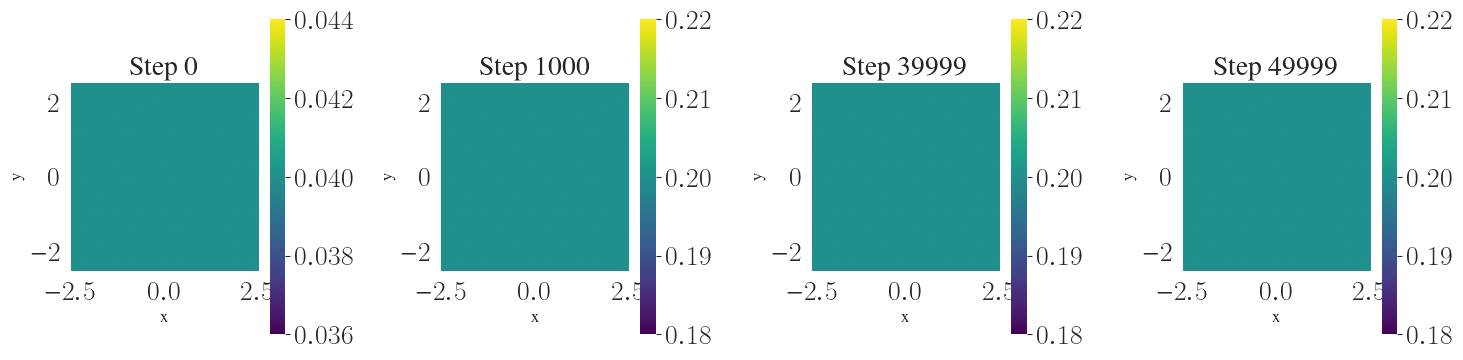

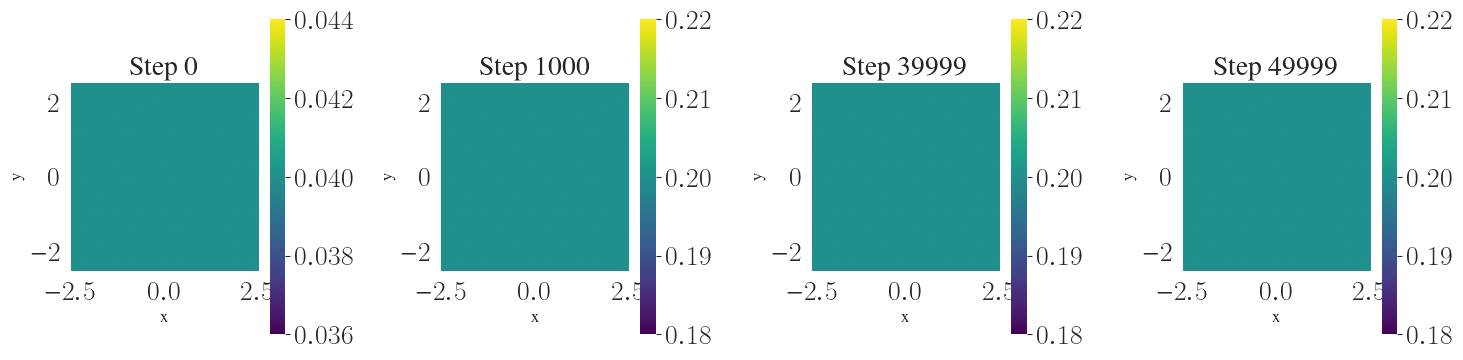

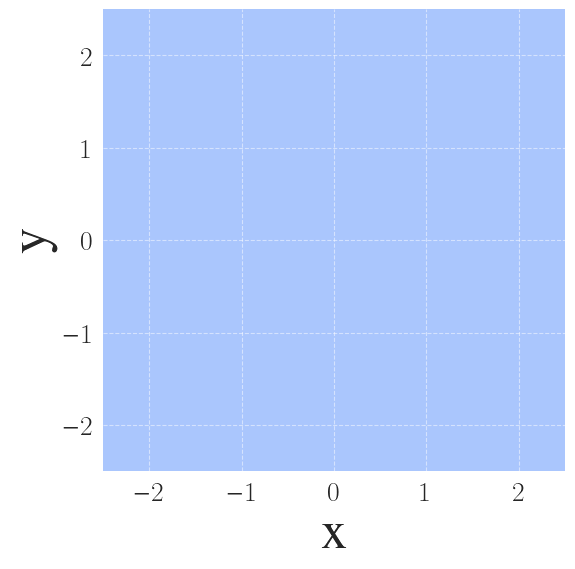

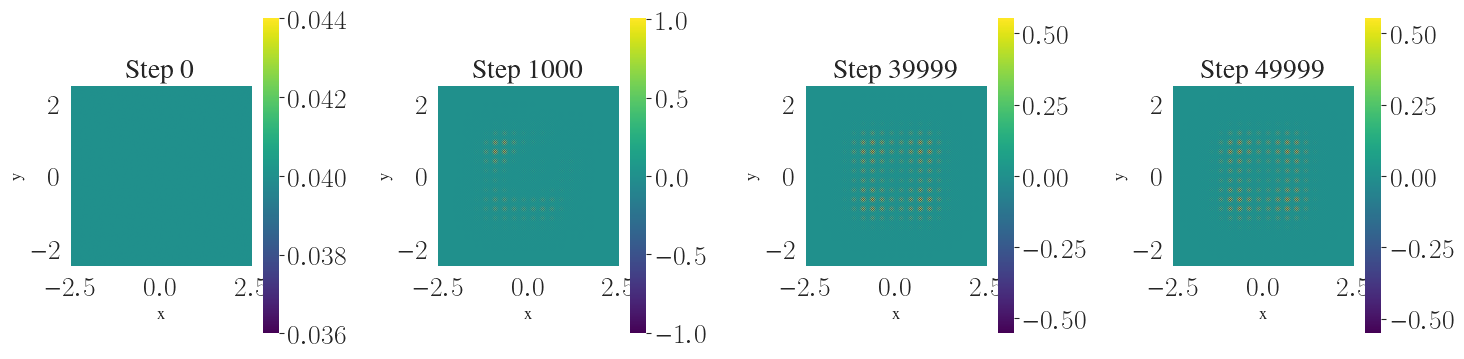

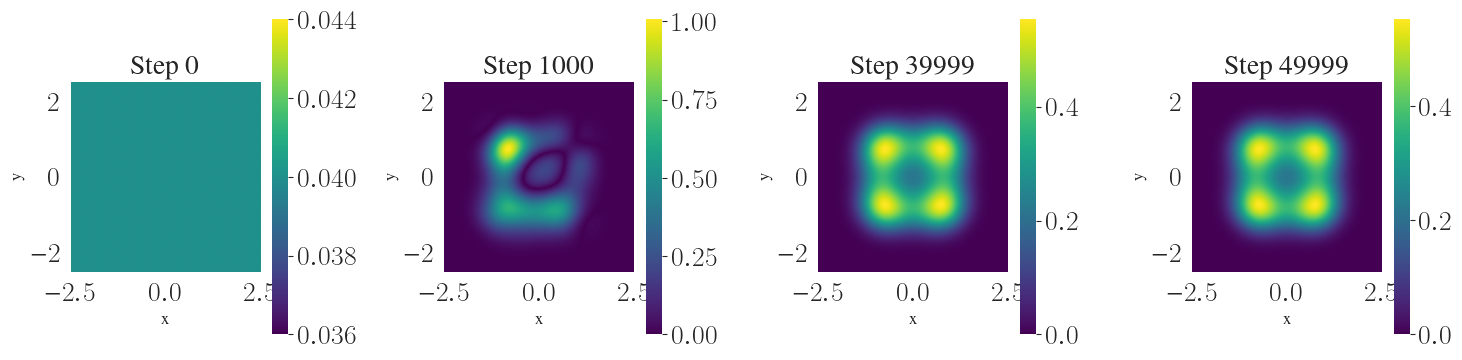

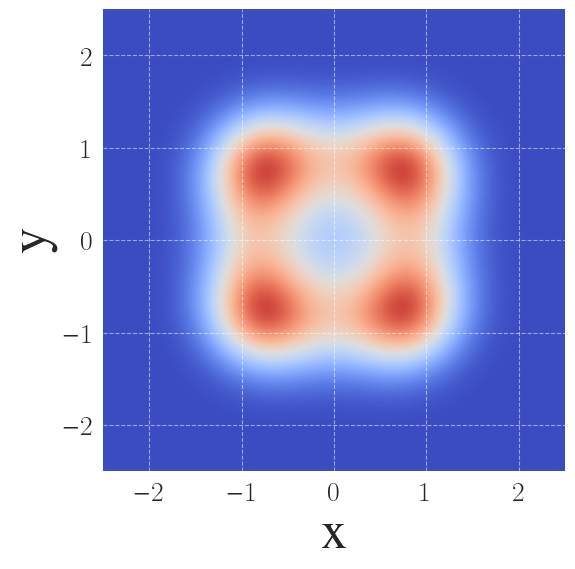

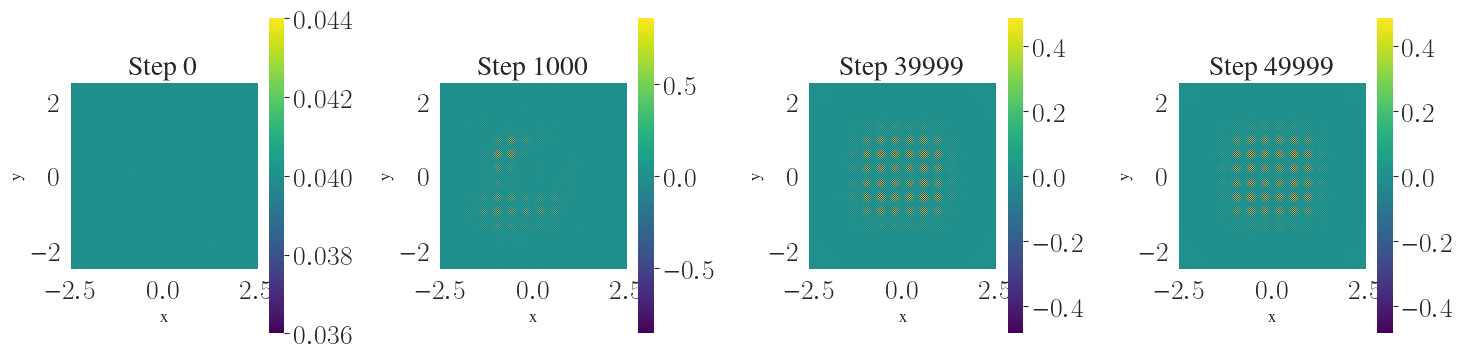

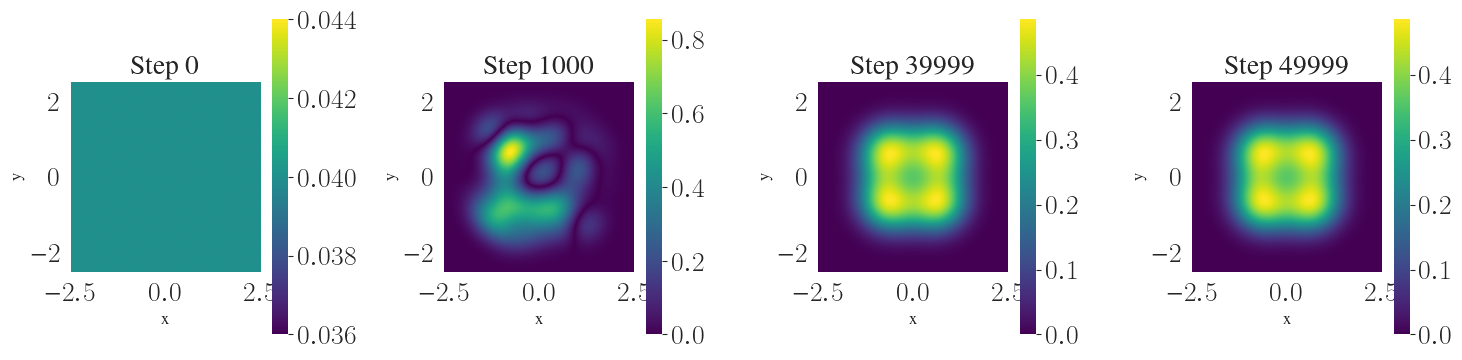

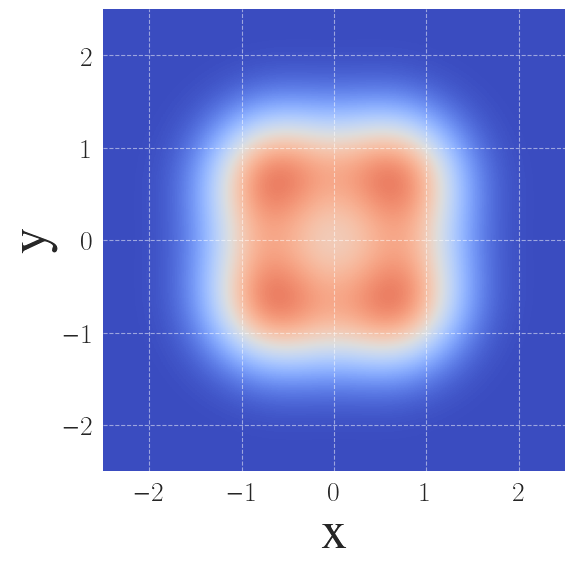

In [21]:
# -------------------------
# Initial condition for f
# -------------------------
# Approximate a delta function by putting all mass in one grid cell.
# f = np.random.randn(nx, ny)
f = np.ones((nx, ny))
f[123, 72] = 1
# Normalize f so that the total area remains 1
total_area = np.sum(np.abs(f)) * dx * dy
if total_area != 0:
    f /= total_area




# -------------------------
# Time-stepping simulation
# -------------------------
epsilon1 = 1   # time step size (diffusion parameter)
n_steps = 50000      # total number of steps
plot_steps = [0, 1000, 39999, 49999]  # steps at which to store snapshots

# ------------------- Simulating Laplacian ------------------

# For plotting, store snapshots of f at selected time steps
f_snapshots = {}
f_snapshots_t = {}
f0 = f.copy()
for step in range(n_steps + 1):
    if step in plot_steps:
        f_snapshots[step] = f.copy()
    # Update f by applying the diffusion operator S_ε
    f = f - laplacian_operator(f ,mu, tilde_mu, epsilon1)
    # f = f - np.mean(f)
    
    # Normalize f so that the total area remains 1
    total_area = np.sqrt(np.sum(f ** 2) * dx * dy)
    if total_area != 0:
        f /= total_area


# -------------------------
# Plotting snapshots
# -------------------------
fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(f_snapshots[step], extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/lap_eigenvector.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(np.abs(f_snapshots[step]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/lap_eigenvector_abs.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

# save nice looking figures 
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(np.abs(f_snapshots[plot_steps[-1]]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='coolwarm', vmin=0, vmax=0.6) 
ax.set_xlabel('x', fontsize=label_fontsize)
ax.set_ylabel('y', fontsize=label_fontsize)
# plt.title('Local Diffusion Direction Quiver Plot')
ax.set_xlim([-Lx/2, Lx/2])
ax.set_ylim([-Ly/2, Ly/2])
ax.grid(True)
plt.savefig(f'{figures_path}/lap_eigenfunction.pdf', dpi=500, format='pdf', bbox_inches='tight')

# ------------------- Simulating Laplacian bar ------------------
# For plotting, store snapshots of f at selected time steps
f_snapshots = {}
f_snapshots_t = {}
f = f0
for step in range(n_steps + 1):
    if step in plot_steps:
        f_snapshots[step] = f.copy()
    # Update f by applying the diffusion operator S_ε
    f = f - laplacian_bar_operator(f ,mu, tilde_mu, epsilon1)
    # f = f - np.mean(f)
    
    # Normalize f so that the total area remains 1
    total_area = np.sqrt(np.sum(f ** 2) * dx * dy)
    if total_area != 0:
        f /= total_area


# -------------------------
# Plotting snapshots
# -------------------------
fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(f_snapshots[step], extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/lap_bar_eigenvector.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(np.abs(f_snapshots[step]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/lap_bar_eigenvector_abs.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


# save nice looking figures 
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(np.abs(f_snapshots[plot_steps[-1]]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='coolwarm', vmin=0, vmax=0.6) 
ax.set_xlabel('x', fontsize=label_fontsize)
ax.set_ylabel('y', fontsize=label_fontsize)
# plt.title('Local Diffusion Direction Quiver Plot')
ax.set_xlim([-Lx/2, Lx/2])
ax.set_ylim([-Ly/2, Ly/2])
ax.grid(True)
plt.savefig(f'{figures_path}/lap_bar_eigenfunction.pdf', dpi=500, format='pdf', bbox_inches='tight')

# ------------------- Simulating Mean Laplacian ------------------
# For plotting, store snapshots of f at selected time steps
f_snapshots = {}
f_snapshots_t = {}
f = f0
for step in range(n_steps + 1):
    if step in plot_steps:
        f_snapshots[step] = f.copy()
    # Update f by applying the diffusion operator S_ε
    f = f - 0.5*(laplacian_bar_operator(f ,mu, tilde_mu, epsilon1) + laplacian_operator(f ,mu, tilde_mu, epsilon1))
    # f = f - (0.25*laplacian_bar_operator(f ,mu, tilde_mu, epsilon1) + 0.75*laplacian_operator(f ,mu, tilde_mu, epsilon1))
    # f = f - np.mean(f)
    
    # Normalize f so that the total area remains 1
    total_area = np.sqrt(np.sum(f ** 2) * dx * dy)
    if total_area != 0:
        f /= total_area


# -------------------------
# Plotting snapshots
# -------------------------
fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(f_snapshots[step], extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/lap_mean_eigenvector.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 4))
for ax, step in zip(axes, plot_steps):
    im = ax.imshow(np.abs(f_snapshots[step]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='viridis')
    ax.set_title(f"Step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)
plt.savefig(f'{figures_path}/lap_mean_eigenvector_abs.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


# save nice looking figures 
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(np.abs(f_snapshots[plot_steps[-1]]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                   origin='lower', cmap='coolwarm', vmin=0, vmax=0.6) 
ax.set_xlabel('x', fontsize=label_fontsize)
ax.set_ylabel('y', fontsize=label_fontsize)
# plt.title('Local Diffusion Direction Quiver Plot')
ax.set_xlim([-Lx/2, Lx/2])
ax.set_ylim([-Ly/2, Ly/2])
ax.grid(True)
plt.savefig(f'{figures_path}/lap_mean_eigenfunction.pdf', dpi=500, format='pdf', bbox_inches='tight')